In [79]:
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from collections import Counter

# Carica dati
edges = pd.read_csv('dataset/spoti/edges.csv')
nodes = pd.read_csv('dataset/spoti/nodes.csv')
nodes_unique = nodes.drop_duplicates(subset=['spotify_id'], keep='first')


In [ ]:
def is_italian(genres):
    if isinstance(genres, str) and 'ital' in genres.lower():
        return True
    return False

nodes_ita = nodes_unique[nodes_unique.apply(lambda row: is_italian(row['genres']), axis=1)]
italian_ids = set(nodes_ita['spotify_id'])
print(f"Artisti italiani identificati: {len(italian_ids)}")


Artisti italiani identificati: 1073


In [81]:
# Edge list: solo collaborazioni TRA italiani
tt = edges[edges['id_0'].isin(italian_ids) & edges['id_1'].isin(italian_ids)]
G_it = nx.Graph()
G_it.add_edges_from(tt[['id_0', 'id_1']].values)
attr_dict = nodes_ita.set_index('spotify_id').to_dict('index')
nx.set_node_attributes(G_it, attr_dict)

print(f"Nodi italiani: {G_it.number_of_nodes()}")
print(f"Collaborazioni italiane: {G_it.number_of_edges()}")

# Calcola degree, ordina e prendi i Top 100
deg_cent = {n: G_it.degree(n) for n in G_it.nodes()}
top100 = [n for n, d in sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:200]]

# Sottografo solo Top100 (e collaborazioni tra loro)
G_top = G_it.subgraph(top100).copy()
print(f"Nodi nel grafo Top 100: {G_top.number_of_nodes()}\nCollaborazioni Top 100: {G_top.number_of_edges()}")


Nodi italiani: 835
Collaborazioni italiane: 3070
Nodi nel grafo Top 100: 200
Collaborazioni Top 100: 1690


In [58]:
deg_top100 = {n: G_top.degree(n) for n in G_top.nodes()}
top_deg = sorted(deg_top100.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 artisti italiani per collaborazioni (tra i Top 100):")
for aid, val in top_deg:
    n = G_top.nodes[aid].get('name', '?')
    print(f"{n} ({aid}): {val}")


Top 10 artisti italiani per collaborazioni (tra i Top 100):
Guè (7F2utINZ6tSokSiZTQBE27): 80
Gemitaiz (4upwdFMlZBmQ68jP9jPzjK): 63
Night Skinny (2E6AK3UPEGCvjnzuygCh2h): 58
Emis Killa (6FtwCmLY6L1sqvjaQ2lV6G): 56
Jake La Furia (6JFRI91YaCXREGQYzHSnUH): 48
Fabri Fibra (7u710e44HW3K7A5eTnRqHC): 45
Marracash (5AZuEF0feCXMkUCwQiQlW7): 45
Don Joe (3WrMBQYO99lzSOhYGPiVoQ): 45
MadMan (3MkkSf3u5KU52Mb2iMrqeX): 43
Clementino (0ba6wsfB7G2rhdHMebCdO3): 42


In [59]:
followers = [(n, float(G_top.nodes[n].get('followers', 0))) for n in G_top.nodes()]
top_followers = sorted(followers, key=lambda x: x[1], reverse=True)[:10]
print('Top italiani per followers (tra i Top 100):')
for aid, val in top_followers:
    print(f"{G_top.nodes[aid].get('name','?')} ({aid}): {int(val)}")


Top italiani per followers (tra i Top 100):
Sfera Ebbasta (23TFHmajVfBtlRx5MXqgoz): 4975040
Capo Plaza (5SulO4l40qDuV9zUGLZx7n): 3330055
Ghali (3egWSWp7Y4FyCKIyvXbw7L): 2880294
Jovanotti (7tmMPdOmFvdRvbj2aWoiRi): 2290094
Salmo (3hBQ4zniNdQf1cqqo6hzuW): 2272768
Andrea Bocelli (3EA9hVIzKfFiQI0Kikz2wo): 2221093
J-AX (2iK8weavvfS2xJCmzNzNE5): 2027080
Guè (7F2utINZ6tSokSiZTQBE27): 1982665
Gemitaiz (4upwdFMlZBmQ68jP9jPzjK): 1917138
Coez (5dXlc7MnpaTeUIsHLVe3n4): 1913149


In [60]:
partition = community_louvain.best_partition(G_top)
num_communities = len(set(partition.values()))
print(f"\nNumero di cluster (Louvain, Top 100): {num_communities}")
comm_sizes = Counter(partition.values())
print("Top 5 community per dimensione:")
for cid, count in comm_sizes.most_common(5):
    print(f"Community {cid}: {count} artisti")



Numero di cluster (Louvain, Top 100): 5
Top 5 community per dimensione:
Community 4: 55 artisti
Community 2: 54 artisti
Community 0: 53 artisti
Community 1: 22 artisti
Community 3: 16 artisti


In [61]:
btw = nx.betweenness_centrality(G_top)
top_btw = sorted(btw.items(), key=lambda x: x[1], reverse=True)[:10]
print('Top italiani "ponte" tra community (tra i Top 100):')
for aid, val in top_btw:
    print(f"{G_top.nodes[aid].get('name','?')} ({aid}): {val:.4f}")


Top italiani "ponte" tra community (tra i Top 100):
Guè (7F2utINZ6tSokSiZTQBE27): 0.0901
Gemitaiz (4upwdFMlZBmQ68jP9jPzjK): 0.0487
J-AX (2iK8weavvfS2xJCmzNzNE5): 0.0469
Night Skinny (2E6AK3UPEGCvjnzuygCh2h): 0.0436
Clementino (0ba6wsfB7G2rhdHMebCdO3): 0.0435
Emis Killa (6FtwCmLY6L1sqvjaQ2lV6G): 0.0416
Jake La Furia (6JFRI91YaCXREGQYzHSnUH): 0.0299
Marracash (5AZuEF0feCXMkUCwQiQlW7): 0.0274
Elisa (2ARH58Hit3yC6ziGdhma23): 0.0274
Don Joe (3WrMBQYO99lzSOhYGPiVoQ): 0.0269


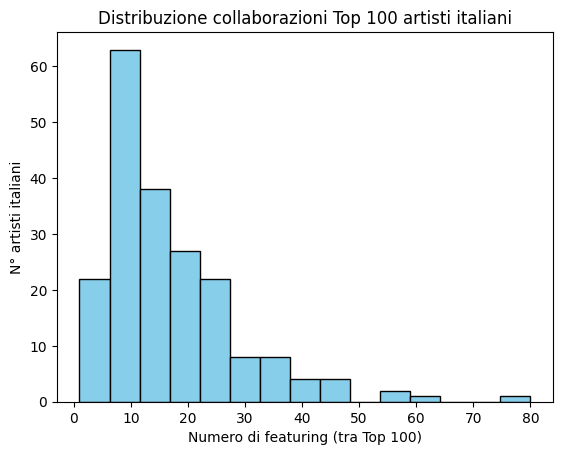

In [62]:
vals = list(deg_top100.values())
plt.hist(vals, bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Numero di featuring (tra Top 100)')
plt.ylabel('N° artisti italiani')
plt.title('Distribuzione collaborazioni Top 100 artisti italiani')
plt.show()


In [ ]:
nx.write_gexf(G_top, "spotify_collab_top200_italians.gexf")
print("File Gephi pronto: solo Top 100 italiani e le loro collaborazioni tra loro")

File Gephi pronto: solo Top 100 italiani e le loro collaborazioni tra loro


In [78]:
import networkx as nx

# Supponi di voler trovare il path da "Guè" a "Marracash"
name1 = "Nayt"
name2 = "Måneskin"

# Trova lo spotify_id per ciascun nome
id1 = nodes.loc[nodes['name'].str.lower() == name1.lower(), 'spotify_id'].iloc[0]
id2 = nodes.loc[nodes['name'].str.lower() == name2.lower(), 'spotify_id'].iloc[0]

# Calcola il path minimo nella rete
shortest = nx.shortest_path(G, source=id1, target=id2)
# Se vuoi la lunghezza:
length = nx.shortest_path_length(G, source=id1, target=id2)

# Visualizza con nomi
print(' -> '.join([G.nodes[n].get('name', n) for n in shortest]))
print(f"Lunghezza path: {length}")


Nayt -> Vegas Jones -> Måneskin
Lunghezza path: 2
